# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# Install all required packages
!pip install smdebug
!pip install -U 
!pip install torchvision torch --no-cache-dir


ERROR: You must give at least one requirement to install (see "pip help install")


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [30]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate 
!unzip dogImages.zip

--2025-03-23 12:08:23--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.220.240, 52.219.120.248, 52.219.117.168, ...
connected. to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.220.240|:443... 
  Unable to locally verify the issuer's authority.
200 OKequest sent, awaiting response... 
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  43.2MB/s    in 28s     

2025-03-23 12:08:51 (38.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.

In [50]:
# General macros
session = sagemaker.Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-003106665031
AWS Region: us-east-1
RoleArn: arn:aws:iam::003106665031:role/service-role/AmazonSageMaker-ExecutionRole-20250323T124278


In [51]:
# Create metadata csv files with keys: path, classification to mimic MNIST dataset description.
# It will be easier to create proper dataloader for these data
import os
import csv

def create_metadata(database_path):
    with open(os.path.join(database_path, 'meta.csv'), 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Filename'])
        for root, dirs, files in os.walk(database_path):
            files.sort()
            for file in files:
                if file.lower().endswith('.jpg'):
                    classification_id = int(root.split("/")[2].split(".")[0])-1
                    rel_path = os.path.join(root, file)
                    row = [classification_id, rel_path]
                    writer.writerow(row)
    print('Creating metadata completed for file', os.path.join(database_path, 'meta.csv'))
                    
create_metadata('dogImages/test')
create_metadata('dogImages/train')
create_metadata('dogImages/valid')

Creating metadata completed for file dogImages/test/meta.csv
Creating metadata completed for file dogImages/train/meta.csv
Creating metadata completed for file dogImages/valid/meta.csv


In [52]:
# Create labels map
database_path = 'dogImages'

def create_labels_map(database_path):
    output_filename = os.path.join(database_path, 'labels.csv')
    with open(output_filename, 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Breed name'])
        for root, dirs, files in os.walk(os.path.join(database_path, 'test')):
            dirs.sort()
            for directories in dirs:
                splitted_dir_name = directories.split(".")
                if (len(splitted_dir_name) == 2 and len(splitted_dir_name[0])>0):
                    splitted_dir_name[0] = int(splitted_dir_name[0]) - 1
                    writer.writerow(splitted_dir_name)
            break
    print('Creating labels map completed. Output', output_filename)
    
create_labels_map(database_path)

Creating labels map completed. Output dogImages/labels.csv


In [53]:
# Print statistics about the dataset
import pandas as pd
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')
valid_meta = pd.read_csv('dogImages/valid/meta.csv')
train_meta = pd.read_csv('dogImages/train/meta.csv')

print('There are %d total dog categories.' % len(labels_map))
print('There are %s total dog images.\n' % str(len(test_meta)+len(valid_meta)+len(train_meta)))
print('There are %d training dog images.' % len(train_meta))
print('There are %d validation dog images.' % len(valid_meta))
print('There are %d test dog images.'% len(test_meta))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


[03/23/25 12:58:43] INFO     generated new fontManager                                         ]8;id=571157;file:///opt/conda/lib/python3.11/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=341391;file:///opt/conda/lib/python3.11/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

label Greater_swiss_mountain_dog id 79
label Bernese_mountain_dog id 22
label Black_and_tan_coonhound id 24
label Entlebucher_mountain_dog id 64
label Kerry_blue_terrier id 92
label English_toy_spaniel id 63
label Lakeland_terrier id 96
label Irish_terrier id 86
label Kerry_blue_terrier id 92


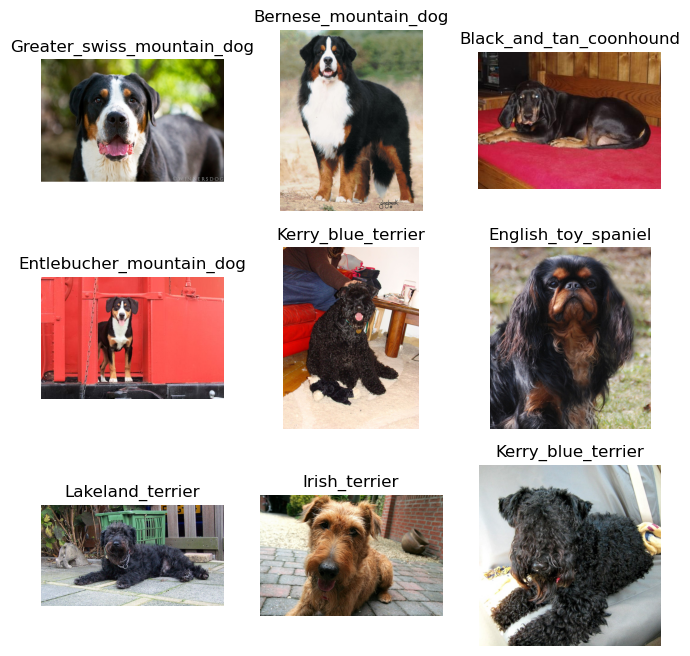

In [54]:
# Plot some of the data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(test_meta))
    img_path = test_meta.iloc[sample_idx, 1]
    label_id = test_meta.iloc[sample_idx, 0]
    label = labels_map.iloc[int(label_id), 1]
    print("label", label, "id", label_id)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(img_path).squeeze(), cmap="gray")
plt.show()
figure.savefig('sample_dataset_images.png')

In [55]:
# Create test image loader for HPO
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class DogBreedDataset(Dataset):
    def __init__(self, annotations_file, base_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.base_dir = base_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        label = int(self.img_labels.iloc[idx, 0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [56]:
# Display image and label.
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
# Some magic values which are equally the same across multiple examples for different datasets.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_transform = transforms.Compose([
    transforms.Resize([256, ]),
    transforms.CenterCrop(224),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=std)])
training_data = DogBreedDataset(annotations_file = 'dogImages/train/meta.csv', base_dir = '.', transform = image_transform)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().numpy().transpose(1,2,0)
label = train_labels[0]
plt.imshow(img*std+mean)
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


[03/23/25 12:59:13] WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=145000;file:///opt/conda/lib/python3.11/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=54304;file:///opt/conda/lib/python3.11/site-packages/matplotlib/image.py#661\661]8;;\
                             for floats or [0..255] for integers). Got range                                       
                             [2.7418136649970393e-09..1.0000000076293944].                                         

Label: 90


In [57]:
# Upload data to S3 for training
import os

os.environ["DATABASE_PATH"] = "s3://"+ bucket+ "/dogImages/"
!aws s3 cp dogImages ${DATABASE_PATH} --recursive

upload: dogImages/labels.csv to s3://sagemaker-us-east-1-003106665031/dogImages/labels.csv
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-003106665031/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://sagemaker-us-east-1-003106665031/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-003106665031/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://sagemaker-us-east-1-003106665031/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg to s3://sagemaker-us-east-1-003106665031/dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://sagemaker-us-east-1-00310

In [33]:
!aws s3 cp --recursive --quiet ./dogImages 's3://sagemaker-us-east-1-003106665031/data/'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [58]:
# Declare HP ranges and metrics
hyperparameter_ranges = {
    "lr": sagemaker.tuner.ContinuousParameter(0.001, 0.1),
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [59]:
# Create estimator
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

In [60]:
# Create tuner
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [61]:
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/model/" # where model will be stored
tuner.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=False)

[03/23/25 13:01:23] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=223277;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=854268;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=636367;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=268549;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

[03/23/25 13:01:24] WARNING  No finished training job found associated with this estimator.       ]8;id=136309;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=302841;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=621708;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=58549;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=498049;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=381123;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=126455;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=796444;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#3383\3383]8;;\
                             pytorch-training-250323-1301                                                          

In [69]:
tuner.best_training_job()

'pytorch-training-250323-1301-001-f3b192e8'

In [70]:
top_estimator = tuner.best_estimator()

top_estimator.hyperparameters()


2025-03-23 13:12:07 Starting - Preparing the instances for training
2025-03-23 13:12:07 Downloading - Downloading the training image
2025-03-23 13:12:07 Training - Training image download completed. Training in progress.
2025-03-23 13:12:07 Uploading - Uploading generated training model
2025-03-23 13:12:07 Completed - Resource reused by training job: pytorch-training-250323-1301-003-4baa5f65


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'lr': '0.059206353253585024',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2025-03-23-13-01-23-624"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-01-23-624/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [71]:
hyperparameter_values = {
    "lr": 0.0014738112822062317,
    "batch-size": 32,
}

In [72]:
# Set up debugging rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [73]:
# Set up profiling rules
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

[03/23/25 13:13:55] WARNING  Framework profiling will be deprecated from tensorflow 2.12 and     ]8;id=762386;file:///opt/conda/lib/python3.11/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=702069;file:///opt/conda/lib/python3.11/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             pytorch 2.0 in sagemaker>=2.                                                          
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [74]:
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameter_values,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [75]:
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/model_train/" # where model will be stored
estimator.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=False)
job_name = estimator._current_job_name
print('Job name:', job_name)
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug artifacts path', debug_artifacts_path)

[03/23/25 13:14:03] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=938973;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=533141;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=672770;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=381082;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

[03/23/25 13:14:04] INFO     Ignoring unnecessary instance type: None.                            ]8;id=797962;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=837342;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=165324;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=884885;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=983633;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=958928;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=826088;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=449201;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=153479;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=292485;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=442681;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=893450;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=503882;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=218755;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2025-03-23-13-14-03-765                                              

Job name: pytorch-training-2025-03-23-13-14-03-765
Debug artifacts path s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/debug-output


In [76]:
import boto3
session = boto3.session.Session()
region = session.region_name

if not job_name:
    job_name = "pytorch-training-2025-03-23-13-14-03-765" # put a job name here to load it
estimator = sagemaker.estimator.Estimator.attach(job_name)

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


..25-03-23 13:14:20 Starting - Preparing the instances for training
...........13:14:40 Downloading - Downloading input data
....-03-23 13:15:41 Downloading - Downloading the training image
.....................................................d completed. Training in progress.
.025-03-23 13:20:37 Uploading - Uploading generated training model
2025-03-23 13:20:50 Completed - Training job completed
Training jobname: pytorch-training-2025-03-23-13-14-03-765
Region: us-east-1


In [78]:
!pip install bokeh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 150.2 MB/s eta 0:00:00


In [79]:
# Wait for training to finish
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-003106665031/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/profiler-output


Profiler data from system is available


In [84]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [85]:
import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed", "Failed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(10) # in seconds

In [87]:
# Check Training Performance
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

if not debug_artifacts_path:
    debug_artifacts_path = "s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/debug-output/"

trial = create_trial(debug_artifacts_path)

[2025-03-23 13:26:59.073 default:163 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/debug-output


In [88]:
trial.tensor_names()

[2025-03-23 13:27:07.752 default:163 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-03-23 13:27:08.771 default:163 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [90]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))


42

In [91]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))


33

In [92]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig('training_debug_values.png')

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


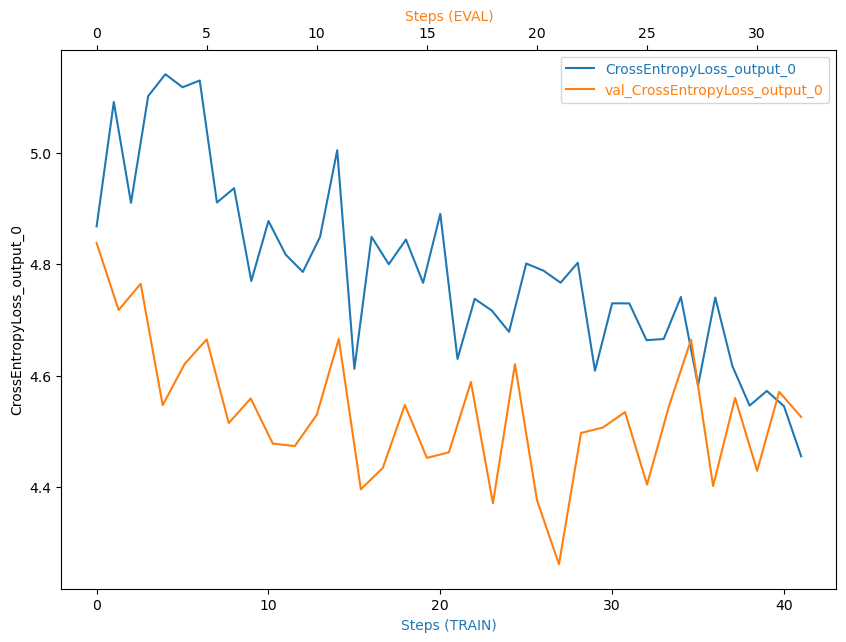

In [94]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

***Display profiler report***

In [95]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/rule-output


In [96]:
! aws s3 ls {rule_output_path} --recursive

2025-03-23 13:20:58     365310 pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-report.html
2025-03-23 13:20:58     212361 pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2025-03-23 13:20:53        191 pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2025-03-23 13:20:53        199 pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2025-03-23 13:20:53       2245 pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2025-03-23 13:20:53        127 pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2025-03-23 13:20:53        198 pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-re

In [97]:
! aws s3 cp {rule_output_path} ./ --recursive


download: s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/rule-output/ProfilerRepor

In [98]:
import os, IPython
# get the autogenerated folder name of profiler report
profiler_report_name = [rule["RuleConfigurationName"] for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]
                       ][0]

print(profiler_report_name)
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

ProfilerReport


## Model Deploying

In [99]:
# create ImagePredictor - without it the Image function won't be able to decode bytes
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [100]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-03-765/output/model.tar.gz


In [101]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [102]:
# This command takes long time to execute - it creates an endpoint
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

[03/23/25 13:33:14] INFO     Repacking model artifact                                                  ]8;id=212818;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=770759;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py#821\821]8;;\
                             (s3://sagemaker-us-east-1-003106665031/pytorch-training-2025-03-23-13-14-             
                             03-765/output/model.tar.gz), script artifact (None), and dependencies                 
                             ([]) into single tar.gz file located at                                               
                             s3://sagemaker-us-east-1-003106665031/pytorch-inference-2025-03-23-13-33-             
                             14-270/model.tar.gz. This may take some time depending on model size...               

[03/23/25 13:33:24] INFO     Creating model with name: pytorch-inference-2025-03-23-13-33-24-040    ]8;id=517509;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=958297;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=962229;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=362483;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5937\5937]8;;\
                             pytorch-inference-2025-03-23-13-33-24-872                                             

[03/23/25 13:33:25] INFO     Creating endpoint with name pytorch-inference-2025-03-23-13-33-24-872  ]8;id=1304;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=636022;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4759\4759]8;;\

--------!

In [128]:
with open("test_image.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)

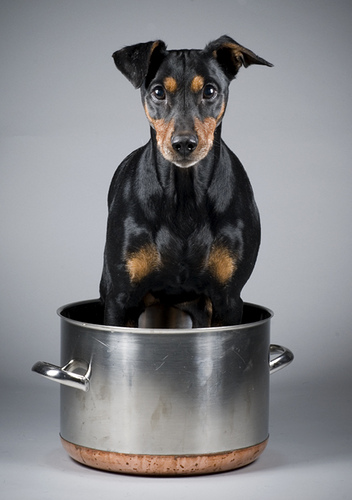

In [129]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [130]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})


In [131]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(133), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[-0.6108867526054382, -0.6545884609222412, 0.06879688054323196, -0.6955851316452026, -0.8033605217933655, -0.5821338295936584, 0.06589741259813309, 0.5452224612236023, -1.2449290752410889, -0.7957770228385925, 0.1009131520986557, -0.5488710999488831, -0.6649032831192017, -1.0526312589645386, -0.28337883949279785, -0.3017059564590454, 0.0509672537446022, -0.12221813946962357, -0.47988080978393555, -0.6682968139648438, -0.411555677652359, -1.049652099609375, -0.7640071511268616, -0.5329294204711914, -1.0506442785263062, -1.1282318830490112, -0.27541279792785645, -0.6030462384223938, 0.40825724601745605, -0.35493138432502747, -0.3710481524467468, 0.3982321619987488, -1.8138662576675415, -0.11142377555370331, -1.2071081399917603, 0.33777397871017456, -0.16813816130161285, -0.24564583599567413, -0.13106605410575867, 0.02200338989496231, -0.03996279463171959, -0.31879377365112305, 0.05810104310512543, 0.26236870884895325, -0.5668484568595886, 0.18807250261306763, -0.4

**Test image is a 'German Pincher', which has classification id of 70. So predicted results are correct**

In [132]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

[03/23/25 13:49:45] INFO     Deleting endpoint configuration with name:                             ]8;id=895890;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=51651;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4913\4913]8;;\
                             pytorch-inference-2025-03-23-13-33-24-872                                             

                    INFO     Deleting endpoint with name: pytorch-inference-2025-03-23-13-33-24-872 ]8;id=35630;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=348357;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4903\4903]8;;\